In [111]:
from gurobipy import *
import numpy as np
import pandas as pd
from Hourbid import *
from Fibid import *
from blockbid import *


In [112]:
HourBid()[1]

,ID,OrderID,Hour,BitType,Quantity,price,Duration,LinkID
0,12,1000,1,S,72621.0,2000.00,1,NaN
1,12,999,1,S,72689.0,1997.85,1,NaN
2,12,998,1,S,72776.0,1995.12,1,NaN
3,12,997,1,S,72817.0,1993.83,1,NaN
4,12,996,1,S,72883.0,1991.78,1,NaN
...,...,...,...,...,...,...,...,...
23995,242,5,24,S,188173.0,7.40,1,NaN
23996,242,4,24,S,189823.0,5.48,1,NaN
23997,242,3,24,S,191878.0,3.49,1,NaN
23998,242,2,24,S,197783.0,0.26,1,NaN


In [113]:
BS_bids = Blockbid()[0]
BD_bids = Blockbid()[1]
HS_bids = HourBid()[0]
HD_bids = HourBid()[1]
FS_bids = Fibid()[0]
FD_bids = Fibid()[1]

In [114]:
np.shape(BD_bids)

(85, 8)

In [115]:
L_D = len(BD_bids)
L_S = len(Blockbid()[0])

In [116]:
Delta_S = np.zeros([L_S,24])


Delta_D = np.zeros([L_D,24])
BD_bids  = Blockbid()[1]
for i in range (L_D):
    if BD_bids['Hour'][i]+BD_bids['Duration'][i]<=25:
        Delta_D[i,BD_bids['Hour'][i]-1:(BD_bids['Hour'][i]+BD_bids['Duration'][i])-1] = 1

BS_bids = Blockbid()[0]
for i in range (L_S):
    if BS_bids['Hour'][i]+BS_bids['Duration'][i]<=25:
        Delta_S[i,BS_bids['Hour'][i]-1:(BS_bids['Hour'][i]+BS_bids['Duration'][i])-1] = 1

In [117]:
def find_F(Del,leng,bids):
    Res = [[] for i in range(24)]
    Res_max = [[] for i in range(24)]
    Res_min = [[] for i in range(24)]
    for i in range (24):
        for j in range(leng):
            if Del[j,i] == 1:
                Res[i].append(bids['price'][j])
    for i in range(24):
        Res_max[i] = np.max(Res[i])
        Res_min[i] = np.min(Res[i])
    return(Res_max,Res_min)

FD_min = np.min(FD_bids['price'])
FD_max = np.max(FD_bids['price'])
FS_min = np.min(FS_bids['price'])
FS_max = np.max(FS_bids['price'])

In [118]:
HD_bids['price'][HIndex_D[1][1]]

0.0

In [119]:
HIndex_D[1][1]

1999

In [120]:
DMax_Res = [[] for i in range(24)]
Dm_Res = [[] for i in range(24)]
SMax_Res = [[] for i in range(24)]
Sm_Res = [[] for i in range(24)]

for i in range(24):
    DMax_Res[i].append(HD_bids['price'][HIndex_D[i][0]])
    DMax_Res[i].append(find_F(Delta_D,L_D,BD_bids)[0][i])
    DMax_Res[i].append(FD_max)
    
for i in range(24):
    SMax_Res[i].append(HS_bids['price'][HIndex_S[i][1]])
    SMax_Res[i].append(find_F(Delta_S,L_S,BS_bids)[0][i])
    SMax_Res[i].append(FS_max)
    
for i in range(24):
    Dm_Res[i].append(HD_bids['price'][HIndex_D[i][1]])
    Dm_Res[i].append(find_F(Delta_D,L_D,BD_bids)[1][i])
    Dm_Res[i].append(FD_min)
    
for i in range(24):
    Sm_Res[i].append(HS_bids['price'][HIndex_S[i][0]])
    Sm_Res[i].append(find_F(Delta_S,L_S,BS_bids)[1][i])
    Sm_Res[i].append(FS_min)

In [121]:
def findmin(num1,num2,num3):
    
    return(min([num1,num2,num3]))

def findmax(num1,num2,num3):

    return(max([num1,num2,num3]))


def put_into_list(maximums,minimums):
    F_min = []
    F_max = []
    for x in range(24):
        F_min.append(findmin(minimums[x][0],minimums[x][1],minimums[x][2]))
        F_max.append(findmax(maximums[x][0],maximums[x][1],maximums[x][2]))

    return(F_min,F_max)

In [122]:
E = Model("Energy")
E.params.NonConvex =2
E.update()
J = np.arange(1,find_largest(HIndex_D)+1)
K = np.arange(1,find_largest(HIndex_S)+1)
H = np.arange(1,25)

Set parameter NonConvex to value 2


In [123]:
L_FD = len(Fibid()[1])
L_FS = len(Fibid()[0])
L_FS

29

In [124]:
xD = E.addVars(H,J,ub=1,lb=0,  vtype=GRB.CONTINUOUS, name='xD')
xS = E.addVars(H,J,ub=1,lb=0,  vtype=GRB.CONTINUOUS, name='xS')
w_D = E.addVars(H,J,ub=1,lb=0,  vtype=GRB.BINARY,name ='W_D')
w_S = E.addVars(H,J,ub=1,lb=0,  vtype=GRB.BINARY,name ='W_S')
yD = E.addVars(L_D,ub=1,lb=0,  vtype=GRB.BINARY,name ='yD')
yS = E.addVars(L_S,ub=1,lb=0,  vtype=GRB.BINARY,name ='yS')
F_z = E.addVars(H,lb = 0,vtype=GRB.CONTINUOUS, name='F_Z')
# F_zD = E.addVars(H,lb = 0,vtype=GRB.CONTINUOUS, name='F_ZD')
V_S = E.addVars(H,L_FS,lb=0,vtype=GRB.BINARY,name = 'V_S')
V_D = E.addVars(H,L_FD,lb=0,vtype=GRB.BINARY,name = 'V_D')

In [125]:
E.setObjective(sum(0.5*(2*Pair(j,h,HD_bids,'DP')[0]+xD[h,j]*(Pair(j,h,HD_bids,'DP')[1]-Pair(j,h,HD_bids,'DP')[0]))*xD[h,j]*(Pair(j,h,HD_bids,'DQ')[1]-Pair(j,h,HD_bids,'DQ')[0])for j in J for h in H)
                -sum(0.5*(2*Pair(j,h,HS_bids,'SP')[0]+xS[h,j]*(Pair(j,h,HS_bids,'SP')[1]-Pair(j,h,HS_bids,'SP')[0]))*xS[h,j]*(Pair(j,h,HS_bids,'SQ')[1]-Pair(j,h,HS_bids,'SQ')[0])for j in J for h in H)
                +sum(BD_bids['Duration'][i]*BD_bids['Quantity'][i]*BD_bids['price'][i]*yD[i] for i in range(L_D)) - sum(BS_bids['Duration'][i]*BS_bids['Quantity'][i]*BS_bids['price'][i]*yS[i] for i in range(L_S))
                +sum(FD_bids['Quantity'][i]*FD_bids['price'][i] for i in range(L_FD))*sum(V_D[h,i]for i in range(L_FD) for h in H)-sum(FS_bids['Quantity'][i]*FS_bids['price'][i] for i in range(L_FS))*sum(V_S[h,i]for i in range(L_FS) for h in H)
                +sum(Pair(1,h,HD_bids,'DQ')[0]-Pair(1,h,HD_bids,'DP')[0] for h in H)
                
,GRB.MAXIMIZE)

In [126]:
sum(Pair(j,2,HS_bids,'SP')[1]-Pair(j,2,HS_bids,'SP')[0] for j in J)

2000.0

In [127]:
sum(Pair(j,1,HD_bids,'DP')[1]-Pair(j,1,HD_bids,'DP')[0] for j in J)

-2000.0000000000011

In [128]:
gamma = 100000000000000000000000000000000000

        # (2)
E.addConstrs(-sum((Pair(j,h,HD_bids,'DQ')[1]-Pair(j,h,HD_bids,'DQ')[0]) * xD[h,j] for j in J ) +sum((Pair(j,h,HS_bids,'SQ')[1]-Pair(j,h,HS_bids,'SQ')[0])*xS[h,j] for j in J) -Pair(1,h,HD_bids,'DQ')[0] +Pair(1,h,HS_bids,'SQ')[0] 
                    +sum(Delta_S[i,h-1]*BS_bids['Quantity'][i]*yS[i] for i in range(L_S))  -sum(Delta_D[i,h-1]*BD_bids['Quantity'][i]*yD[i] for i in range(L_D))
                    +sum(FS_bids['Quantity'][i]*V_S[h,i]for i in range(L_FS))-sum(FD_bids['Quantity'][i]*V_D[h,i]for i in range(L_FD))
                    
                    ==0 for h in H) 
 


E.addConstrs(F_z[h] == Sm_Res[h-1][0]+sum((Pair(j,h,HS_bids,'SP')[1]-Pair(j,h,HS_bids,'SP')[0]) * xS[h,j] for j in J)for h in H)        
E.addConstrs(F_z[h] == DMax_Res[h-1][0]+sum((Pair(j,h,HD_bids,'DP')[1]-Pair(j,h,HD_bids,'DP')[0]) * xD[h,j] for j in J) for h in H)
# (8)

E.addConstrs(-BS_bids['Duration'][j]* BS_bids['price'][j]+ sum(Delta_S[j,h-1]*F_z[h] for h in H ) <= yS[j]*gamma for j in range(L_S))
# (9)

E.addConstrs(BD_bids['Duration'][j]*BD_bids['price'][j]- sum(Delta_S[j,h-1]*F_z[h] for h in H) <= yD[j]*gamma for j in range(L_D))
        
    # E.addConstr(if Blockbid['LinkID'][j] == 'NaN': Blockbid['Duration'][j]*Blockbid['price'][j]+ sum(Delta_S[j,h]*F_z[h] for j in J) <= yd[j]*gamma)
        
# (3)(4)
# Demand
E.addConstrs(w_D[h,1]<=xD[h,1] for h in H)
E.addConstrs(xD[h,1] <=1 for h in H)
E.addConstrs(w_D[h,j]<=xD[h,j] for j in range(2,find_largest(HIndex_D)) for h in H)
E.addConstrs(xD[h,j]<=w_D[h,j-1] for j in range(2,find_largest(HIndex_D)) for h in H)
E.addConstrs(0<= xD[h,999] for h in H)
E.addConstrs(xD[h,999] <= w_D[h,998] for h in H)

# Supply
E.addConstrs(w_S[h,1]<=xS[h,1] for h in H)
E.addConstrs(xS[h,1] <=1 for h in H)
E.addConstrs(w_S[h,j]<=xS[h,j] for j in range(2,find_largest(HIndex_S)) for h in H)
E.addConstrs(xS[h,j]<=w_S[h,j-1] for j in range(2,find_largest(HIndex_S)) for h in H)
E.addConstrs(0<= xS[h,999] for h in H)
E.addConstrs(xS[h,999] <= w_S[h,998] for h in H)


E.addConstrs(sum(V_S[h,i] for h in H )<= 1 for i in range(L_FS) )
E.addConstrs(sum(V_D[h,i] for h in H )<= 1 for i in range(L_FD) )

E.addConstrs(F_z[h]-FS_bids['price'][i] <= gamma*sum(V_S[k,i] for k in H) for i in range(L_FS) for h in H)
E.addConstrs(FD_bids['price'][i]-F_z[h]<=gamma*sum(V_D[k,i] for k in H) for i in range(L_FD) for h in H)




{(0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 8): <gurobi.Constr *Awaiting Model Update*>,
 (0, 9): <gurobi.Constr *Awaiting Model Update*>,
 (0, 10): <gurobi.Constr *Awaiting Model Update*>,
 (0, 11): <gurobi.Constr *Awaiting Model Update*>,
 (0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 13): <gurobi.Constr *Awaiting Model Update*>,
 (0, 14): <gurobi.Constr *Awaiting Model Update*>,
 (0, 15): <gurobi.Constr *Awaiting Model Update*>,
 (0, 16): <gurobi.Constr *Awaiting Model Update*>,
 (0, 17): <gurobi.Constr *Awaiting Model Update*>,
 (0, 18): <gurobi.Constr *Awaiting Model Update*>,
 (0, 19): <gurobi.Constr *Awaiting Model Update*>,
 (0, 20): <gurobi.Constr *Awaiting Model

In [129]:
E.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 97426 rows, 97328 columns and 325405 nonzeros
Model fingerprint: 0xf590ebf7
Model has 47952 quadratic objective terms
Variable types: 47976 continuous, 49352 integer (49352 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+35]
  Objective range  [1e+02, 2e+07]
  QObjective range [2e-02, 3e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 13141 rows and 12485 columns
Presolve time: 1.97s
Presolved: 84285 rows, 84843 columns, 259508 nonzeros
Presolved model has 41723 quadratic objective terms
Variable types: 41747 continuous, 43096 integer (43096 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   12854    1.1475592e+09   0.000000e

In [ ]:
E.getAttr('x',xD)

GurobiError: Unable to retrieve attribute 'x'

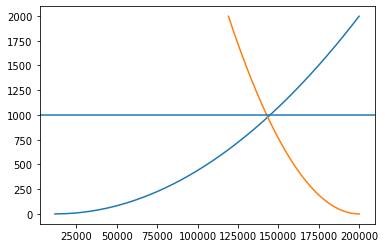

In [ ]:
import matplotlib.pyplot as plt
a = 5000
b = 5999
plt.plot(HS_bids['Quantity'][a:b],HS_bids['price'][a:b])
plt.plot(HD_bids['Quantity'][a:b],HD_bids['price'][a:b])
plt.axhline(y = 997)